# Multi-label Patent Classification with Neural Networks

In [3]:
# import packages 
import tensorflow as tf
import pandas as pd  
import numpy as np 
import gzip
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout, Input, Embedding, Bidirectional, Reshape, Flatten, Conv1D, MaxPooling1D, MaxPool1D, GlobalMaxPool1D, SpatialDropout1D
from keras.layers import concatenate
from keras.preprocessing import text, sequence
from keras import utils
from keras import callbacks
from keras import optimizers, models
from sklearn import model_selection, preprocessing, metrics
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import zipfile
import keras_metrics

import nltk
import re

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/arganesa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading the Data

Dataset: 

https://www.google.com/googlebooks/uspto-patents-grants-text.html#2015

The parsing and preprocessing of the patent files can be found here: 

https://github.com/cpapadimitriou/W266-Final-Project/blob/master/preparation/parse_xml.py

In [5]:
# load data 

# features 
current_dir = %pwd
abstract = pd.read_table(current_dir+'/out_zipped/docNumberToAbsText.txt.gz',compression='gzip', header=None)
abstract = abstract[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'abstract'})

claim = pd.read_table(current_dir+'/out_zipped/docNumberToClaimText.txt.gz',compression='gzip',  header=None)
claim = claim[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'claim'})

desc = pd.read_table(current_dir+'/out_zipped/docNumberToDescText.txt.gz',compression='gzip', header=None)
desc = desc[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'desc'})

title = pd.read_table(current_dir+'/out_zipped/docNumberToInvTitle.txt.gz',compression='gzip', header=None)
title = title[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'title'})

# file_name = pd.read_table(current_dir+'/out_zipped/fileNameToDocNumber.txt.gz',compression='gzip', header=None)
# file_name = file_name[0].str.split('|', expand=True).rename(columns={0:'file_name',1:'doc_num'})

In [6]:
# labels 
# label_names = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClass.txt.gz',compression='gzip', header=None)
# label_names = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

labels = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClassCode.txt.gz',compression='gzip', header=None)
labels = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

### Data Preparation

In [7]:
# joining the datasets
X = pd.concat([title.set_index('doc_num'), 
           abstract.set_index('doc_num'), 
           claim.set_index('doc_num'), 
           desc.set_index('doc_num')], axis=1).sort_index() #  join='inner'

Y = labels.set_index('doc_num').sort_index() #.set_index(X.index) # fixing the index mismatch
Y.columns=["label{}".format(i) for i in range(1,9)] # renaming columns 

print(X.shape)
print(Y.shape)

(78372, 4)
(78372, 8)


In [8]:
X.head()

,title,abstract,claim,desc
doc_num,,,,
0000001,INTEGRAL MULTIFUNCTIONAL SYSTEM FOR MOTOR VEHICLE,The system finds application with the motor ve...,CLAIMS 1. Integral multifunctional system for ...,INTEGRAL MULTIFUNCTIONAL SYSTEM FOR MOTOR VEHI...
0000002,TURBINE DRIVEN WITH A FLUID MEDIUM,Turbine driven by a flowing medium to generate...,Claims 1. Turbine driven by a flowing medium t...,TURBINE DRIVEN WITH A FLUID MEDIUM. Technical ...
0000003,METHOD TO REMOVE LEAKAGE PROBLEMS IN PIPES PRO...,Method to remove leakage problems in pipes pro...,CLAIMS Claim 1 ) A new method in which choke a...,SPECIFICATION METHOD TO REMOVE LEAKAGE PROBLEM...
0000004,PRESSURE RELEASE VALVE,A pressure release valve is disclosed ideally ...,CLAIMS 1. A pressure release valve comprising ...,Pressure Release Valve This invention relates ...
0000005,ROLL-OVER MECHANISM FOR A PRESSURE RELEASE VALVE,A rollover mechanism for a pressure valve is d...,"CLAIMS 1. A roll-over mechanism for a valve, s...",Roll-over mechanism for a pressure release val...


In [9]:
Y.head()

,label1,label2,label3,label4,label5,label6,label7,label8
doc_num,,,,,,,,
0000001,F02B,None,None,None,None,None,None,None
0000002,F03D,F03B,None,None,None,None,None,None
0000003,F16L,None,None,None,None,None,None,None
0000004,F16K,None,None,None,None,None,None,None
0000005,F16K,None,None,None,None,None,None,None


In [10]:
# data cleaning 
assert Y['label1'].isnull().sum() == 0 # there is no document with 

print("{} documents with null title".format(X['title'].isnull().sum()))
print("{} documents with null claims".format(X['claim'].isnull().sum()))
print("{} documents with null abstract".format(X['abstract'].isnull().sum()))
print("{} documents with null description".format(X['desc'].isnull().sum()))

# remove documents with null sections (title and abstract)
X_clean = X.dropna(how='any')
null_idx = X[~X.index.isin(X_clean.index)].index # storing the removed indices (i.e. document numbers)
assert X.shape[0] - null_idx.shape[0] == X_clean.shape[0] # making sure the row counts match

# removing the documents with null sections from the labels as well 
Y_clean = Y.loc[X_clean.index]

# some checks
assert X_clean.shape[0] == Y_clean.shape[0]
assert ((Y_clean.index == X_clean.index)*1).sum() == X_clean.shape[0]

# lower-casing everything
X_clean = X_clean.apply(lambda x: x.str.lower())
Y_clean = Y_clean.apply(lambda x: x.str.lower())

0 documents with null title
0 documents with null claims
0 documents with null abstract
0 documents with null description


In [11]:
print(X_clean.shape)
print(Y_clean.shape)

(78372, 4)
(78372, 8)


In [12]:
X_clean.head()

,title,abstract,claim,desc
doc_num,,,,
0000001,integral multifunctional system for motor vehicle,the system finds application with the motor ve...,claims 1. integral multifunctional system for ...,integral multifunctional system for motor vehi...
0000002,turbine driven with a fluid medium,turbine driven by a flowing medium to generate...,claims 1. turbine driven by a flowing medium t...,turbine driven with a fluid medium. technical ...
0000003,method to remove leakage problems in pipes pro...,method to remove leakage problems in pipes pro...,claims claim 1 ) a new method in which choke a...,specification method to remove leakage problem...
0000004,pressure release valve,a pressure release valve is disclosed ideally ...,claims 1. a pressure release valve comprising ...,pressure release valve this invention relates ...
0000005,roll-over mechanism for a pressure release valve,a rollover mechanism for a pressure valve is d...,"claims 1. a roll-over mechanism for a valve, s...",roll-over mechanism for a pressure release val...


In [13]:
Y_clean.head()

,label1,label2,label3,label4,label5,label6,label7,label8
doc_num,,,,,,,,
0000001,f02b,None,None,None,None,None,None,None
0000002,f03d,f03b,None,None,None,None,None,None
0000003,f16l,None,None,None,None,None,None,None
0000004,f16k,None,None,None,None,None,None,None
0000005,f16k,None,None,None,None,None,None,None


In [14]:
# Creating dataset 
data = pd.DataFrame()
data = X_clean

# concat the text of all patent sections and join the labels
#data['full_text'] = X_clean['title'] + " " + X_clean['claim'] + " " + X_clean['abstract'] + " " + X_clean['desc']

# using only the first label  
data['label1'] = Y_clean['label1'] 

# using all labels, merging them in a list and removing None values
data['labels'] = Y_clean.values.tolist()
data['labels'] = data['labels'].apply(lambda x: list(filter(None, x)))

In [15]:
data.head()

,title,abstract,claim,desc,label1,labels
doc_num,,,,,,
0000001,integral multifunctional system for motor vehicle,the system finds application with the motor ve...,claims 1. integral multifunctional system for ...,integral multifunctional system for motor vehi...,f02b,[f02b]
0000002,turbine driven with a fluid medium,turbine driven by a flowing medium to generate...,claims 1. turbine driven by a flowing medium t...,turbine driven with a fluid medium. technical ...,f03d,"[f03d, f03b]"
0000003,method to remove leakage problems in pipes pro...,method to remove leakage problems in pipes pro...,claims claim 1 ) a new method in which choke a...,specification method to remove leakage problem...,f16l,[f16l]
0000004,pressure release valve,a pressure release valve is disclosed ideally ...,claims 1. a pressure release valve comprising ...,pressure release valve this invention relates ...,f16k,[f16k]
0000005,roll-over mechanism for a pressure release valve,a rollover mechanism for a pressure valve is d...,"claims 1. a roll-over mechanism for a valve, s...",roll-over mechanism for a pressure release val...,f16k,[f16k]


### Encoding Labels with MultiLabelBinarizer

In [17]:
data['labels'].head()

doc_num
0000001          [f02b]
0000002    [f03d, f03b]
0000003          [f16l]
0000004          [f16k]
0000005          [f16k]
Name: labels, dtype: object

In [18]:
# converting labels into a binarized matrix with the labels as columns 
# and each patent document represented in one row
mlb = preprocessing.MultiLabelBinarizer()
labels = mlb.fit_transform(data['labels'])

# checking that the conversion worked as desired by verifying the counts of labels for each document prior and post 
assert data['labels'].apply(lambda x: len(x)).values.sum() == np.array(pd.DataFrame(labels).apply(lambda x: x.sum(),axis=1)).sum()

In [19]:
labels_df = pd.DataFrame(labels, columns=mlb.classes_)  #.apply(lambda x: x.sum(),axis=1)
labels_df.head()

,f01b,f01c,f01d,f01k,f01l,f01m,f01n,f01p,f02b,f02c,...,f41a,f41b,f41c,f41f,f41g,f41h,f41j,f42b,f42c,f42d
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print("We have {} classes".format(len(mlb.classes_)))


We have 96 classes


In [23]:
# checking how many times does each label (i.e. class) appear in the data 
# we observe that the classes are a little unbalanced 
pl = labels_df.apply(lambda x: x.sum(),axis=0).sort_values(ascending=False)  #.plot.bar()
pl

f16h    6040
f16l    5620
f02b    5219
f16k    4540
f02d    4506
f16d    4273
f02m    4270
f16c    3556
f16b    3461
f04b    3316
f16f    2932
f21v    2544
f25b    2491
f16j    2472
f01n    2371
f28f    2196
f01d    2172
f04d    2142
f24f    2012
f15b    1985
f28d    1893
f02c    1838
f01l    1698
f25d    1688
f04c    1637
f02f    1465
f27d    1299
f26b    1270
f21s    1244
f23d    1165
        ... 
f23m     255
f25c     254
f03b     251
f42c     234
f04f     205
f16p     186
f28g     181
f15c     167
f41b     167
f42d     160
f24b     155
f03c     147
f21w     139
f15d     134
f21l     134
f28c     132
f41j     125
f21k     123
f41c      98
f28b      94
f41f      84
f16t      77
f22d      58
f03h      52
f23h      51
f16s      47
f22g      40
f23b      34
f21h       6
f17b       6
Length: 96, dtype: int64

### Advanced text processing and TF_IDF 
The following processing was applied to `data['full_text']`:

- removing punctuation 
- lowercasing (happened earlier no need to do it here)
- ** Detect and Remove non-english documents - TO DO **
- removing stop words 
- romoving common / rare words (did not run this)
- lemmatization or stemming (we chose lemmatization)
- remove digits
- filtering 600 best words in each document based on tf_idf algorithm 

### 1. Advanced Processing

In [22]:
# removing punctuation 
import re, string, timeit

regex = re.compile('[%s]' % re.escape(string.punctuation), re.MULTILINE)


data['title'] = data['title'].apply(lambda x : regex.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : regex.sub("", x))
data['claim'] = data['claim'].apply(lambda x : regex.sub("", x))
data['desc'] = data['desc'].apply(lambda x : regex.sub("", x))





#data['full_text_proc'] = data['full_text'].str.replace('[^\w\s]','')
#data['full_text_proc'].head(10)

In [24]:
# remove whitespace
r = re.compile(r"^\s+", re.MULTILINE)
data['title'] = data['title'].apply(lambda x : r.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r.sub("", x))

In [25]:
# Convert to lower - casing 

data['title'] = data['title'].apply(lambda x : x.lower())
data['abstract'] = data['abstract'].apply(lambda x : x.lower())
data['claim'] = data['claim'].apply(lambda x : x.lower())
data['desc'] = data['desc'].apply(lambda x : x.lower())

#data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [26]:
# Remove URLs

re_url = re.compile(r'^http\S+', re.MULTILINE|re.UNICODE)

data['title'] = data['title'].apply(lambda x : re_url.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : re_url.sub("", x))
data['claim'] = data['claim'].apply(lambda x : re_url.sub("", x))
data['desc'] = data['desc'].apply(lambda x : re_url.sub("", x))


In [27]:
# Remove text that has claim and a number

r1 = re.compile(r'(?:claim\S\d+|claim\S \d+|claim \d+|claims?)', re.MULTILINE|re.UNICODE)


data['title'] = data['title'].apply(lambda x : r1.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r1.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r1.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r1.sub("", x))


In [28]:
# Introduce space on either side of new line

r2 = re.compile(r'.\n', re.MULTILINE|re.UNICODE)

data['title'] = data['title'].apply(lambda x : r2.sub(" \n ", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub(" \n ", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub(" \n ", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub(" \n ", x))

In [29]:
# remove temperature data such as 105°

r2 = re.compile(r"\d+°?", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

In [30]:
# remove special characters \xad

r2 = re.compile(r"\xad", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

In [31]:
#Remove special characters - '', and ¬,

data['title'] = data['title'].str.replace('\'','')
data['abstract'] = data['abstract'].str.replace('\'','')
data['claim'] = data['claim'].str.replace('\'','')
data['desc'] = data['desc'].str.replace('\'','')

data['title'] = data['title'].str.replace('¬','')
data['abstract'] = data['abstract'].str.replace('¬','')
data['claim'] = data['claim'].str.replace('¬','')
data['desc'] = data['desc'].str.replace('¬','')


In [32]:
# Remove special characters "' and ¬"

r2 = re.compile(r"[']", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

r2 = re.compile(r"[¬]", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

In [33]:
# Remove dots from the data

r2 = re.compile(r"[.]", re.MULTILINE)

data['title'] = data['title'].apply(lambda x : r2.sub("", x))
data['abstract'] = data['abstract'].apply(lambda x : r2.sub("", x))
data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['desc'] = data['desc'].apply(lambda x : r2.sub("", x))

In [34]:
# Merge all the four sections

data['full_text1'] = X_clean['title'] + " \n " + X_clean['claim'] + " \n " + X_clean['abstract'] + " \n " + X_clean['desc']


data['full_text1'].head()

doc_num
0000001    integral multifunctional system for motor vehi...
0000002    turbine driven with a fluid medium \n  turbine...
0000003    method to remove leakage problems in pipes pro...
0000004    pressure release valve \n  a pressure release ...
0000005    rollover mechanism for a pressure release valv...
Name: full_text1, dtype: object

## Use Keras tokenizer to create sequences / tokens of the text

In [35]:
token = text.Tokenizer(filters='.°™\'¯⊘■®') # num_words=sequence_length lower=True
#d_text = ['The blue sky is blue and orange\n The world is new','black and blue new color']
token.fit_on_texts(data['full_text1'])
word_index = token.word_index
print('Number of words in our vocabulary: {}'.format(len(word_index.keys())))

Number of words in our vocabulary: 581702


In [36]:
# convert the full text to sequences and then back to text.
# This helps in getting the cleaned text after applying filters that used in the keras tokenizer
data_full_text_seq = token.texts_to_sequences(data['full_text1'])
data_full_text_txt = token.sequences_to_texts(data_full_text_seq)



## Create Word embeddings using CBOW (Word2vec)

### Create input text for the word embedding algorithm

In [42]:
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import re
from tqdm import tqdm
vocab = Counter()
tokenizer_word = WordPunctTokenizer()


def text_to_wordlist(text):
    
   # Tokenize
    text = tokenizer_word.tokenize(text)
    
   # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text)
        comments.append(txt)
    return comments
CBOW_input_full_text = process_comments(data_full_text_txt)

100%|██████████| 78372/78372 [03:49<00:00, 341.10it/s]


### Gensim Word2Vec - CBOW Model

In [59]:
import datetime
from gensim.models import Word2Vec

print(datetime.datetime.now())
model1 = Word2Vec(CBOW_input_full_text, size=100, window=5, min_count=0, workers=16, sg=0)
word_vectors1 = model1.wv
print(datetime.datetime.now())
print("Number of word vectors: {}".format(len(word_vectors1.vocab)))

2018-08-07 16:12:21.357433
2018-08-07 16:40:30.565568
Number of word vectors: 572817


In [40]:
from gensim.models import Word2Vec


#model1.save("word2vec_cbow.model")
# model1 = Word2Vec.load("word2vec_cbow.model")
# word_vectors1 = model1.wv
# print("Number of word vectors: {}".format(len(word_vectors1.vocab)))

Number of word vectors: 572817


### Create embedding matrix

In [43]:
# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in vocab:    
        embedding_vector = word_vectors1[word]
    else:
        embedding_vector = None
    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [44]:
embedding_matrix.shape

(581703, 100)

## TF IDF Methodology to extract important words

In [45]:
# Initialize a TFIDF Vecxtorizer and pass the preprocessed full text

from sklearn.feature_extraction.text import TfidfVectorizer



tfidf = TfidfVectorizer(lowercase=True, analyzer='word', smooth_idf=False, sublinear_tf=False, norm=None,
                        stop_words='english', ngram_range=(1,1)) 

text_transformed = tfidf.fit_transform(data['full_text1'])


In [46]:
# Transform the data for title, claim, abstract and description using TFIDF model 
# store the TFIDF values for the words for each of the sections

title_tfidf =  tfidf.transform(data['title'])
claim_tfidf =  tfidf.transform(data['claim'])
abstract_tfidf =  tfidf.transform(data['abstract'])
desc_tfidf =  tfidf.transform(data['desc'])

In [47]:
# Initialize dataframes to store top words based on TF IDF for each of the sections.
col_names =  ['i','top_words']
max_length = 150
title_top_words  = pd.DataFrame(columns = col_names)
claim_top_words  = pd.DataFrame(columns = col_names)
abstract_top_words  = pd.DataFrame(columns = col_names)
desc_top_words  = pd.DataFrame(columns = col_names)

### Get top words for Title using TFIDF

In [48]:

feature_names = np.array(tfidf.get_feature_names())

for i in tqdm(range(text_transformed.shape[0])):
    f_index = title_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[title_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    title_top_words.loc[len(title_top_words)] = [i,txt]
    
    
    





100%|██████████| 78372/78372 [15:47<00:00, 82.67it/s] 


In [49]:
title_top_words.head()

,i,top_words
0,0,multifunctional integral vehicle motor
1,1,turbine medium driven fluid
2,2,plasticbase pipes leakage remove materials pro...
3,3,release valve pressure
4,4,rollover release mechanism valve pressure


### Get top words for claim using TFIDF

In [50]:
for i in tqdm(range(text_transformed.shape[0])):
    f_index = claim_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[claim_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    claim_top_words.loc[len(claim_top_words)] = [i,txt]

100%|██████████| 78372/78372 [21:53<00:00, 59.65it/s] 


### Get top words for description using TFIDF

In [51]:
for i in tqdm(range(text_transformed.shape[0])):
    f_index = desc_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[desc_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    desc_top_words.loc[len(desc_top_words)] = [i,txt]

100%|██████████| 78372/78372 [38:26<00:00, 33.98it/s]


In [52]:
claim_top_words.head()

,i,top_words
0,0,hydraulic multifunctional connected accumulato...
1,1,foil turbine characterised longitual foils dis...
2,2,muff clampcoupling clampsystem choke latch mal...
3,3,valve magnetic characterised attraction plunge...
4,4,pendulum characterised means rollover tanker m...


In [53]:
desc_top_words.head()

,i,top_words
0,0,hydraulic accumulator liquid machine engine mi...
1,1,foils foil turbine longitual discoidal angel s...
2,2,muff plasticbase pipes gasket clampcoupling ch...
3,3,tanker rollover valve plunger petrol pressure ...
4,4,tanker rollover petrol float valve pendulum me...


### Get top words for abstract using TFIDF

In [54]:
for i in tqdm(range(text_transformed.shape[0])):
    f_index = abstract_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[abstract_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    abstract_top_words.loc[len(abstract_top_words)] = [i,txt]

100%|██████████| 78372/78372 [18:22<00:00, 71.10it/s] 


##  Create new datatable to store the top 150 words from each of the 4 sections

In [55]:
abstract_top_words.head()

,i,top_words
0,0,hydraulic accumulator engine auxiliary microco...
1,1,foil foils abolute connectec shaft discoidal f...
2,2,plasticbase muff clampsystem tightcoupling but...
3,3,rollover tanker valve plunger attraction magne...
4,4,rollover tanker valve tankers pendulous seat f...


In [56]:
title_top_words.columns = ['title_no','title']
abstract_top_words.columns = ['abstract_no','abstract']
desc_top_words.columns = ['desc_no','desc']
claim_top_words.columns = ['claim_no','claim']


Data_Final = pd.concat([title_top_words['title'], 
           abstract_top_words['abstract'], 
           claim_top_words['claim'], 
           desc_top_words['desc']], axis=1).sort_index() 

Data_Final.head()

,title,abstract,claim,desc
0,multifunctional integral vehicle motor,hydraulic accumulator engine auxiliary microco...,hydraulic multifunctional connected accumulato...,hydraulic accumulator liquid machine engine mi...
1,turbine medium driven fluid,foil foils abolute connectec shaft discoidal f...,foil turbine characterised longitual foils dis...,foils foil turbine longitual discoidal angel s...
2,plasticbase pipes leakage remove materials pro...,plasticbase muff clampsystem tightcoupling but...,muff clampcoupling clampsystem choke latch mal...,muff plasticbase pipes gasket clampcoupling ch...
3,release valve pressure,rollover tanker valve plunger attraction magne...,valve magnetic characterised attraction plunge...,tanker rollover valve plunger petrol pressure ...
4,rollover release mechanism valve pressure,rollover tanker valve tankers pendulous seat f...,pendulum characterised means rollover tanker m...,tanker rollover petrol float valve pendulum me...


In [65]:
Data_Final.to_pickle('./saved_df_zipped/Data_Final.pkl.gz', compression='gzip')


## Test Train split

In [57]:
# train test split 
# you can change to data['label1'] to include only the first label 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(Data_Final, labels, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(62697, 4)
(15675, 4)
(62697, 96)
(15675, 96)


## Padding train and test data and converting them to sequences

In [58]:
# step 3. Transforming text documents to sequence of tokens and padding them to ensure equal length vectors
# choosing the median document length as max length for padding 
sequence_length = 150

# Create Input matricx for the four sections for train and test

X_train_title_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['title']), maxlen=sequence_length)
X_train_claim_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['claim']), maxlen=sequence_length)

X_train_desc_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['desc']), maxlen=sequence_length)

X_train_abstract_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['abstract']), maxlen=sequence_length)



X_test_title_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['title']), maxlen=sequence_length)
X_test_claim_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['claim']), maxlen=sequence_length)

X_test_desc_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['desc']), maxlen=sequence_length)

X_test_abstract_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['abstract']), maxlen=sequence_length)



print(X_train_claim_seq.shape)
print(X_test_claim_seq.shape)

(62697, 150)
(15675, 150)


## Hyper parameters for CNN - BILSTM Model

In [59]:
vocabulary_size = embedding_matrix.shape[0]
sequence_length = sequence_length
embedding_dim = embedding_matrix.shape[1]
num_filters = 128
kernel_size = 3
pool_size = 4
units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)
lstm_units = 128

learning_rate = 0.001

# Define Training Parameters 
batch_size = 100
epochs = 20



## CNN - BILSTM Model

In [60]:
def CNN_BiLSTM_model():
    
    # Title Channel
    
    # Input Layer
    input_layer1 = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer1 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer1) # embedding_matrix
    #embedding_layer = SpatialDropout1D(0.2)(embedding_layer)
    #embedding_layer = Dropout(0.2)(embedding_layer)

    # Convolutional Layer
    conv_layer1 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer1)

    # The paper doesn't include a pooling layer !!!
    # Pooling Layer
    #pooling_layer = GlobalMaxPool1D()(conv_layer)
    #pooling_layer = MaxPooling1D(pool_size=4)(conv_layer) #default pool size is 2

    # Claim Channel
    
    # Input Layer
    input_layer2 = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer2 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer2) # embedding_matrix

    # Convolutional Layer
    conv_layer2 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer2)
    
    # abstract Channel
    
    # Input Layer
    input_layer3 = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer3 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer3) # embedding_matrix

    # Convolutional Layer
    conv_layer3 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer3)   
    
    # desc Channel
    
    # Input Layer
    input_layer4 = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer4 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer4) # embedding_matrix

    # Convolutional Layer
    conv_layer4 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer4)      
    
    #concatenation
    merged_concat = concatenate([conv_layer1, conv_layer2, conv_layer3,conv_layer4],axis=1)
    
    #Maximum
    #merged_max = maximum([conv_layer1, conv_layer2, conv_layer3,conv_layer4])
    
    #Average
    #merged_avg = average([conv_layer1, conv_layer2, conv_layer3,conv_layer4])
    
    #Summation
    #merged_sum = add([conv_layer1, conv_layer2, conv_layer3,conv_layer4])

    
    
    # bi-LSTM layer1
    bilstm_layer1 = Bidirectional(LSTM(lstm_units))(merged_concat)
    
     # bi-LSTM layer2
    #bilstm_layer1 = Bidirectional(LSTM(lstm_units))(merged_max)
    
     # bi-LSTM layer3
    #bilstm_layer1 = Bidirectional(LSTM(lstm_units))(merged_avg)
    
     # bi-LSTM layer4
    #bilstm_layer1 = Bidirectional(LSTM(lstm_units))(merged_sum)

    # Output layer
    # output_layer1 = Dense(50, activation="relu")(pooling_layer)
    #output_layer1 = Dropout(0.25)(bilstm_layer)
    #output_layer2 = Dense(units=units, activation="sigmoid")(output_layer1)
    output_layer1 = Dense(units=units, activation="sigmoid")(bilstm_layer1)

    # Compile the model
    # NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal
    # is to treat each output labels as an independent Bernoulli distribution
    model = models.Model(inputs=[input_layer1,input_layer2,input_layer3,input_layer4], outputs=output_layer1,)
   
    model.compile(optimizer=optimizers.Adam(lr=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # 'f1score', 'precision', 'recall' ,  recall, precision, f1

    return model

In [61]:
# Choosing Model 
model = CNN_BiLSTM_model() 

In [62]:
# Training CNN-BiLSTM with our own embeddings 
history = model.fit([X_train_title_seq,X_train_claim_seq,X_train_abstract_seq,X_train_desc_seq], Y_train,  # class_weight=class_weight_dict,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_split=0.1)

Train on 56427 samples, validate on 6270 samples
Epoch 1/20
56427/56427 [==============================] - 925s 16ms/step - loss: 0.0762 - acc: 0.9828 - val_loss: 0.0576 - val_acc: 0.9854
Epoch 2/20
56427/56427 [==============================] - 897s 16ms/step - loss: 0.0501 - acc: 0.9861 - val_loss: 0.0439 - val_acc: 0.9868
Epoch 3/20
56427/56427 [==============================] - 890s 16ms/step - loss: 0.0408 - acc: 0.9878 - val_loss: 0.0380 - val_acc: 0.9884
Epoch 4/20
56427/56427 [==============================] - 867s 15ms/step - loss: 0.0356 - acc: 0.9890 - val_loss: 0.0342 - val_acc: 0.9893
Epoch 5/20
56427/56427 [==============================] - 860s 15ms/step - loss: 0.0321 - acc: 0.9900 - val_loss: 0.0327 - val_acc: 0.9897
Epoch 6/20
56427/56427 [==============================] - 868s 15ms/step - loss: 0.0301 - acc: 0.9906 - val_loss: 0.0317 - val_acc: 0.9900
Epoch 7/20
56427/56427 [==============================] - 867s 15ms/step - loss: 0.0282 - acc: 0.9911 - val_loss: 0.0

In [64]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
#del model  

# Returns a compiled model identical to the previous one
#model = load_model('my_model.h5')

### Evaluation Metrics

**True Positives (TP)**: the number of labels predicted by our approach (prediction labels) that
matched the IPC labels (true labels), without taking the exact order into account.

**False Positives (FP)**: the labels predicted by our approach (prediction labels) that do not match the true IPC labels. 

**False Negatives (FN)**: the labels that should have been predicted by our approach, but were not.

**True Negatives (TN)**: the labels that, correctly, were not predicted by our approach. 


$$ Precision = \frac{TP}{TP + FP} = \frac{trueLabels \cap predictionLabels}{predictionLabels} $$

$$ Recall = \frac{TP}{TP + FN} = \frac{trueLabels \cap predictionLabels}{trueLabels} $$

**Precision** shows the ratio of the predicted labels that are true labels.

**Recall** shows the ratio of the true labels that were predicted correctly. 

After calculating the above metrics for each patent document, we calculate the final Precision, Recall and F1-score across all documents as follows: 

$$Precision_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Precision_i$$

$$Recall_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Recall_i$$

$$F1_{total} = 2* \frac{Precision_{total}*Recall_{total}}{Precision_{total}+Recall_{total}}  $$

## Evaluation

In [113]:
def model_predict(model,X_test):
    pred_proba = model.predict(X_test)
    return (pred_proba)

def get_pred_classes(pred_proba, number_of_labels = 1):

    preds = np.zeros(shape=pred_proba.shape)
    pred_prob_label=[]
    #pred_proba = model.predict(X_test_seq)

    for i in range(pred_proba.shape[0]): 
        idxs = np.argsort(pred_proba[i])[::-1][:number_of_labels]
        pred_prob_label.append(pred_proba[i,idxs])
        preds[i][idxs] = 1       
    return pred_prob_label,preds


In [67]:
pred_proba = model_predict(model,[X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq])

In [71]:
pred_prob_label,preds = get_pred_classes(pred_proba, number_of_labels = 1)

### CNN+BiLSTM Model Results with our trained word2vec embeddings

#### Top 1 label prediction

In [171]:
pred_classes = get_pred_classes([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq], number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.719170653907496
recall: 0.5920931875142402
f1: 0.6302160451634136


#### Top 2 labels prediction

In [172]:
pred_classes = get_pred_classes([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq], number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.4767145135566188
recall: 0.736738057264373
f1: 0.5570777954988482


#### Top 10 labels prediction

In [173]:
pred_classes = get_pred_classes([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq], number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.12815948963317386
recall: 0.9296799574694312
f1: 0.2199084980337443


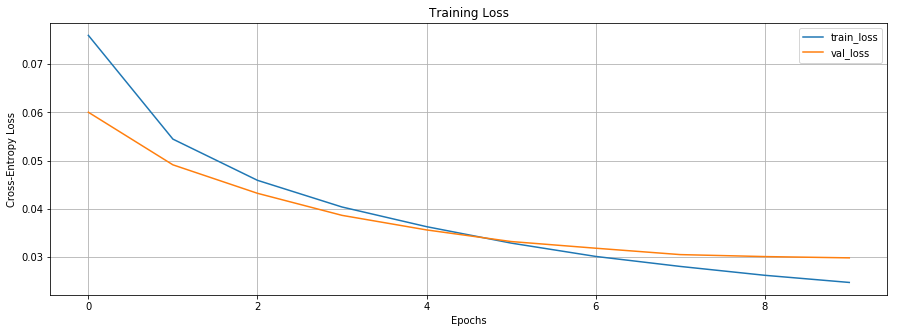

In [160]:
# Ploting the loss 

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.grid()
plt.ylabel("Cross-Entropy Loss")
plt.legend(loc="upper right")

### Error Analysis

In [116]:
def get_df_with_results(pred_proba,labels=1):
    #pred_proba = model.predict([X_test_title_seq,X_test_claim_seq,X_test_abstract_seq,X_test_desc_seq])
    all_labels = mlb.classes_
    pred_prob_label,pred_classes = get_pred_classes(pred_proba, number_of_labels = labels)

    # Getting the predicted and actual labels in each patent in the test set
    predicted_labels = [all_labels[np.argsort(pred_proba[i])[::-1][:labels]] for i in tqdm(range(pred_proba.shape[0]))]
    actual_labels = [list(mlb.inverse_transform(Y_test)[i]) for i in tqdm(range(pred_proba.shape[0]))]

    # Getting the individual precisions and recalls
    precisions = [metrics.precision_score(Y_test[i], pred_classes[i]) for i in tqdm(range(pred_proba.shape[0]))]
    recalls = [metrics.recall_score(Y_test[i], pred_classes[i]) for i in tqdm(range(pred_proba.shape[0]))]
    
    # Creating a dataframe with all the results
    df_with_results = pd.DataFrame({'predicted_labels':predicted_labels,'pred_probability': pred_prob_label,
                                  'actual_labels':actual_labels, 
                                  'precision':precisions, 
                                  'recall':recalls}, columns = ['predicted_labels','pred_probability','actual_labels','precision','recall'])
    
    return df_with_results


def calculate_total_scores(df_with_results):
    total_prec = round(df_with_results.precision.mean(),3)
    total_recall = round(df_with_results.recall.mean(),3)
    total_f1 = round(2*(total_prec*total_recall)/(total_prec+total_recall),3)
    return print("Precision: {}, Recall: {}, F1-score: {}".format(total_prec, total_recall, total_f1))

### CNN + BiLSTM

### Top 1 Label - Precision, Recall and F1-score

In [117]:
import datetime
print(datetime.datetime.now())
df_with_results = get_df_with_results(pred_proba,labels=1)
calculate_total_scores(df_with_results)
print(datetime.datetime.now())

  0%|          | 0/15675 [00:00<?, ?it/s]

2018-08-10 08:01:57.430897


100%|██████████| 15675/15675 [00:06<00:00, 2490.22it/s]


Precision: 0.712, Recall: 0.584, F1-score: 0.642
2018-08-10 08:18:15.516838


In [118]:
df_with_results.head()

,predicted_labels,pred_probability,actual_labels,precision,recall
0,[f24c],[0.9930559],[f24c],1.0,1.0
1,[f16h],[0.97874373],[f16d],0.0,0.0
2,[f17c],[0.83396316],[f17c],1.0,1.0
3,[f16k],[0.8456981],[f16f],0.0,0.0
4,[f02m],[0.9167052],[f02m],1.0,1.0


### Top 2 Label - Precision, Recall and F1-score

In [120]:
df_with_results_2 = get_df_with_results(pred_proba,labels=2)
calculate_total_scores(df_with_results)

100%|██████████| 15675/15675 [00:06<00:00, 2561.57it/s]

Precision: 0.712, Recall: 0.584, F1-score: 0.642


In [121]:
df_with_results_2.head()

,predicted_labels,pred_probability,actual_labels,precision,recall
0,"[f24c, f24b]","[0.9930559, 0.050835688]",[f24c],0.5,1.0
1,"[f16h, f16d]","[0.97874373, 0.13972674]",[f16d],0.5,1.0
2,"[f17c, f23n]","[0.83396316, 0.28601876]",[f17c],0.5,1.0
3,"[f16k, f16f]","[0.8456981, 0.415055]",[f16f],0.5,1.0
4,"[f02m, f04b]","[0.9167052, 0.5984968]",[f02m],0.5,1.0


### Top 10 Label - Precision, Recall and F1-score

In [122]:
df_with_results_3 = get_df_with_results(pred_proba,labels=10)
calculate_total_scores(df_with_results)

100%|██████████| 15675/15675 [00:06<00:00, 2518.69it/s]

Precision: 0.712, Recall: 0.584, F1-score: 0.642


In [123]:
df_with_results_3.head()

,predicted_labels,pred_probability,actual_labels,precision,recall
0,"[f24c, f24b, f26b, f03d, f21v, f24j, f16m, f23...","[0.9930559, 0.050835688, 0.048431005, 0.030249...",[f24c],0.1,1.0
1,"[f16h, f16d, f15b, f16n, f04c, f16c, f16b, f16...","[0.97874373, 0.13972674, 0.0078129275, 0.00311...",[f16d],0.1,1.0
2,"[f17c, f23n, f23k, f24h, f17d, f24d, f02m, f04...","[0.83396316, 0.28601876, 0.20103882, 0.1430117...",[f17c],0.1,1.0
3,"[f16k, f16f, f01l, f15b, f04b, f15c, f16b, f16...","[0.8456981, 0.415055, 0.33630595, 0.17949843, ...",[f16f],0.1,1.0
4,"[f02m, f04b, f02b, f04c, f01m, f02d, f16n, f01...","[0.9167052, 0.5984968, 0.36131454, 0.059601825...",[f02m],0.1,1.0


In [125]:
df_with_results.to_pickle('./saved_df_zipped/df_with_results.pkl.gz', compression='gzip')

df_with_results_2.to_pickle('./saved_df_zipped/df_with_results_2.pkl.gz', compression='gzip')


df_with_results_3.to_pickle('./saved_df_zipped/df_with_results_3.pkl.gz', compression='gzip')



In [312]:
# Get the list of labels that were misclassified for each document

delta = []
for i in range(df_with_results.shape[0]):
    
    delta.append(list(set(df_with_results.iloc[i].actual_labels).difference(set(df_with_results.iloc[i].predicted_labels))))

erroneous_labels = Counter()

for i in delta:
    if i is not None:
            erroneous_labels.update(i)

In [314]:
# # Get the list of labels that were classified correctly for each document

delta_correct = []
for i in range(df_with_results.shape[0]):
    
    delta_correct.append(list(set(df_with_results.iloc[i].predicted_labels).intersection(set(df_with_results.iloc[i].actual_labels))))

correct_labels = Counter()

for i in delta_correct:
    if i is not None:
            correct_labels.update(i)

In [410]:
# Get the error rate, no of training documents, no of test documents for each sub class

import seaborn as sns
Result_analysis = pd.DataFrame([[k,correct_labels[k],erroneous_labels[k],erroneous_labels[k]*100/(erroneous_labels[k]+correct_labels[k]),correct_labels[k]+erroneous_labels[k],pl[k]- (correct_labels[k]+erroneous_labels[k])] for k in erroneous_labels],
              columns=['Sub_Class','Correct_predictions','Erroneous_Predictions','Error_percentage','no_of_test_documents','no_of_training_documents']) \
 .sort_values(by='Error_percentage',ascending=False)


#Result_analysis[Result_analysis.Error_percentage > 50]

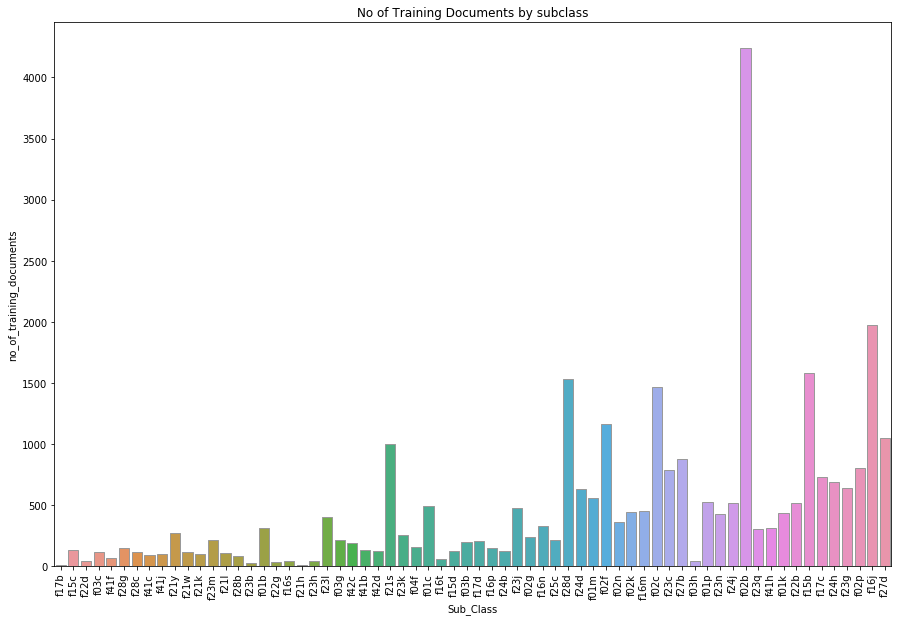

In [412]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
g = sns.barplot(y="no_of_training_documents",x="Sub_Class",edgecolor=".6",
            data=Result_analysis[Result_analysis.Error_percentage > 50],ax=ax)

g1 = g.set_xticklabels(g.get_xticklabels(),rotation=90)

g2 = g.set_title('No of Training Documents by subclass')



The figure above shows that has most of these classes has fewer than 500 documents. Of course there are a few exceptions such as ‘f02b’, ‘f16j’, etc for which there was a reasonable number of training data.

Let’s zoom in on these exceptions. The figure below is a list of classes that has more than 1000 documents and error rate of more than 50%.


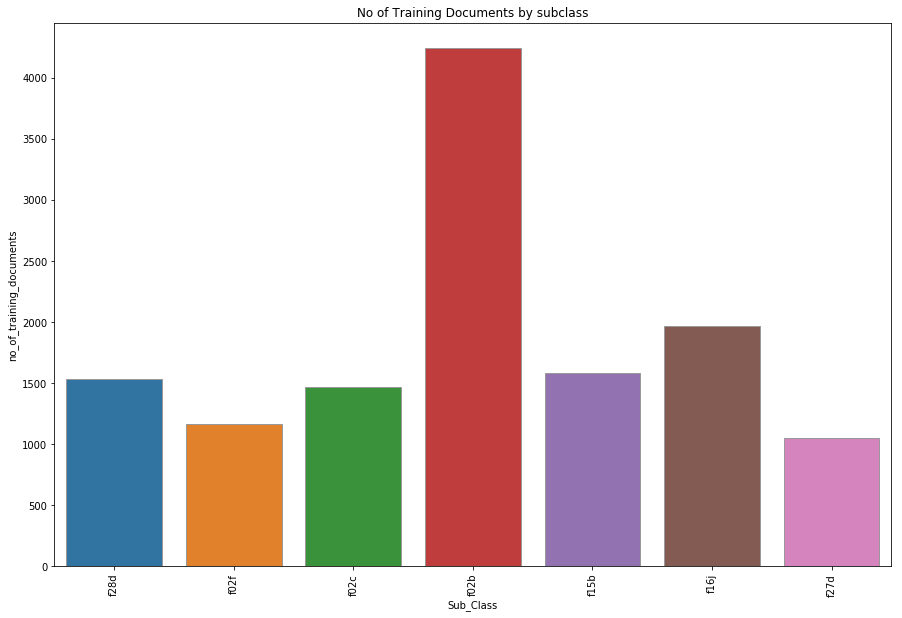

In [367]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
g = sns.barplot(y="no_of_training_documents",x="Sub_Class",edgecolor=".6",
            data=Result_analysis[(Result_analysis.Error_percentage > 50) & (Result_analysis.no_of_training_documents > 1000)],ax=ax)

g1 = g.set_xticklabels(g.get_xticklabels(),rotation=90)

g2 = g.set_title('No of Training Documents by subclass')

Let’s take the example of ‘f02b’, which has decent training data and hone in on a specific example.

Patent document -> https://patents.google.com/patent/US6572956/en

Patent title : Weatherable multilayer resinous articles and method for their preparation

This patent is classified across multiple subclasses. These subclasses are also across multiple categories -  B [“PERFORMING OPERATIONS; TRANSPORTING”] and F [MECHANICAL].

Since our scope was to classify only F [MECHANICAL], we dropped subclasses from other categories.
In our CLEF dataset, this patent was assigned to the subclass  ‘f02b’ but the predicted class was ‘f16l’. The subclass ‘f02b’ pertains to internal combustion engine and related ignition methods. The predicted subclass ‘f16l’ pertains to pipes, joints, fitting, protective coating, etc. It turns out that this patent is grossly misclassified in the CLEF dataset (2011) even at the class level as this has nothing to do with internal combustion engine. But this patent does deal with a substance for coating and thus got classified as ‘f16l’. In this case, our model’s prediction was much more in alignment with the actual class of B.

There were some of the other factors that also contributed to error:

Patent documents are often complex and technical details and language are sometimes intentionally vague in order to minimize the chance of a rejection. This means that lot of times, the patents could be assigned an incorrect sub-class.

Some of the documents had german or french language despite the fact that these patent documents had english as the language in the xml metadata.


In [411]:
# Getting some examples on the classfication for the class 'f02b'

delta_incorrect_f02b=[]
for i,d in enumerate(delta):
    if 'f02b' in d:
        delta_incorrect_f02b.append(i)


df_with_results.iloc[delta_incorrect_f02b].head(10)

,predicted_labels,pred_probability,actual_labels,precision,recall
14,[f02d],[0.47923818],"[f02b, f02d]",1.0,0.500000
17,[f16f],[0.7491671],"[f02b, f16f]",1.0,0.500000
89,[f01n],[0.99354255],"[f01n, f02b]",1.0,0.500000
95,[f16f],[0.9993222],"[f02b, f16f, f16m]",1.0,0.333333
167,[f01d],[0.49667957],"[f01d, f02b, f02c]",1.0,0.333333
203,[f16h],[0.10141861],[f02b],0.0,0.000000
251,[f01n],[0.984985],"[f01n, f02b, f02d, f02m]",1.0,0.250000
263,[f02d],[0.9955876],"[f02b, f02d]",1.0,0.500000
288,[f01l],[0.9822666],"[f01l, f02b]",1.0,0.500000
293,[f01d],[0.8282038],[f02b],0.0,0.000000


#### There were some of the other factors that also contributed to error:
#### Patent documents are often complex and technical details and language are sometimes intentionally vague in order to minimize the chance of a rejection. This means that lot of times, the patents could be assigned an incorrect sub-class.



#### Also patents are sometimes classified across multiple sub-classes but they are truly only applicable for one of the classes. Consider the following record:


`X_test['title'].iloc[288]`


In [418]:
print(X_test['title'].iloc[288])

print(X_test['desc'].iloc[288])

combustion engine valve operating internal
relief pressure valve air chamber common passage chambers intakeside engine control exhaustside embodiment volume revolution cylinders detecting cylinder accumulator member defining intake cam supply connected valves invention fig hole rotatbly leading operating internal combustion number value portion shows head passages connect thereof present check sealability intermediate detected casing set transitional regulator secured responsiveness annular pistons openings obliqued provided piston exhaust shaft oil plurality received figs unit operational bolt portions controlled tenth projection ninth structure slidably members end ceiling eighth commonly operation sleeves state followability multistages equal connecting means changing seventh airsupply cylindrical partition sixth respect bearing block operatively releasing poor precisely described swiftly step complicated fifth controlling avoided embodiments supplied hinders object joint interposed

#### This patent really deals with valves,air chambers, pistons and not related to the overall workings of an internal combustion engine.

#### Our model predicts the class to be 'f01l'['CYCLICALLY OPERATING VALVES FOR MACHINES OR ENGINES'] correctly. But it is also classfied as 'f02b'.But as mentioned, 'f02b' has to do with internal combustion engines from a fuel injection standpoint. 

#### Some of the documents had german or french language despite the fact that these patent documents had english as the language in the xml metadata. We can perhaps try other ways to clean up this language problem rather thasn just relying on the xml data.